In [2]:
#Imports
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import visualkeras
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings("ignore")

#if 'No module named 'visualkeras' error occurs, please use 'pip install visualkeras' in terminal

In [3]:
#Load Images into dataframe and split data into training, testing and validation splits.

df = pd.read_csv('../final_project/IndexedImages.csv') #load csv into pandas dataframe

train_df, validation_df = train_test_split(df, test_size = 0.15) #Validation dataset set to 15%
train_df, test_df =  train_test_split(df, test_size = 0.15) #Test dataset set to 15%

#Pre-processing: balancing weights

train_df['class_int'] = train_df['class_index'].astype(int)
ClassCounts = train_df['class_index'].value_counts().sort_index()
ClassWeights = compute_class_weight('balanced', classes = ClassCounts.index.to_numpy(), y = train_df['class_index'].values)
ClassWeights = dict(zip(ClassCounts.index, ClassWeights))
train_df = train_df.drop(columns=['class_int'])

#conversion of data into strings so keras can pass data through.
train_df['class_index'] = train_df['class_index'].astype(str)
train_df['filename'] = train_df['filename'].astype(str)

test_df['class_index'] = test_df['class_index'].astype(str)
test_df['filename'] = test_df['filename'].astype(str)

validation_df['class_index'] = validation_df['class_index'].astype(str)
validation_df['filename'] = validation_df['filename'].astype(str)


In [4]:
#Model Configuration
################################


ValidationSplit = 0.15 #possibly set as high as 0.5
BatchSize = 32 #worth trying 16, 32, 64
Nepochs = 100
DropoutValue = 0.3

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits = True)

#Define the model

model = keras.models.Sequential()
#First convolutional layer
model.add(keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 128, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))

#Second convolutional layer
model.add(keras.layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

#Third convolutional layer
model.add(keras.layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Flatten())

#Fully connected layers
model.add(keras.layers.Dense(128, activation = 'relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(64, activation = 'relu'))
model.add(keras.layers.Dense(23, activation = tf.keras.activations.softmax)) #23 Possible classifications


In [5]:
#Data Generators

idg = ImageDataGenerator(rescale = 1./255.) #resize images into an appropriate size.

train = idg.flow_from_dataframe(dataframe = train_df, x_col = 'filename', y_col = 'class_index', target_size = (128,128), directory = '/home/jovyan/deep_learning/final_project/Dataset/train', batch_size = BatchSize, class_mode = 'sparse')
test = idg.flow_from_dataframe(dataframe = test_df, x_col = 'filename', y_col = 'class_index', target_size = (128,128), directory = '/home/jovyan/deep_learning/final_project/Dataset/train', batch_size = BatchSize, class_mode = 'sparse', shuffle = False)
validation = idg.flow_from_dataframe(dataframe = validation_df, x_col = 'filename', y_col = 'class_index', target_size = (128,128), directory = '/home/jovyan/deep_learning/final_project/Dataset/train', batch_size = BatchSize, class_mode = 'sparse')

model.summary()
model.compile(optimizer = 'adam', loss = loss_fn, metrics = ['accuracy'])

history = model.fit(train, validation_data = validation, epochs = Nepochs, shuffle = True, class_weight = ClassWeights)

Found 5234 validated image filenames belonging to 23 classes.
Found 924 validated image filenames belonging to 23 classes.
Found 924 validated image filenames belonging to 23 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 con

I0000 00:00:1746220396.125003  272949 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


164/164 [==============================] - 14s 56ms/step - loss: 5.6430 - accuracy: 0.0527 - val_loss: 3.3700 - val_accuracy: 0.0411
Epoch 2/100
164/164 [==============================] - 7s 45ms/step - loss: 5.2491 - accuracy: 0.0579 - val_loss: 3.4066 - val_accuracy: 0.0411
Epoch 3/100
164/164 [==============================] - 7s 45ms/step - loss: 4.8475 - accuracy: 0.0728 - val_loss: 2.7972 - val_accuracy: 0.1299
Epoch 4/100
164/164 [==============================] - 7s 44ms/step - loss: 4.4888 - accuracy: 0.1013 - val_loss: 2.6323 - val_accuracy: 0.1558
Epoch 5/100
164/164 [==============================] - 7s 45ms/step - loss: 3.9053 - accuracy: 0.1431 - val_loss: 2.4993 - val_accuracy: 0.2035
Epoch 6/100
164/164 [==============================] - 7s 44ms/step - loss: 3.5319 - accuracy: 0.1783 - val_loss: 2.3023 - val_accuracy: 0.2727
Epoch 7/100
164/164 [==============================] - 8s 46ms/step - loss: 3.2864 - accuracy: 0.2300 - val_loss: 1.9458 - val_accuracy: 0.3626
Epo

history keys =  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Display the evolution of the accuracy as a function of the training epoch
  N(Epochs)        =  100
  accuracy (train) =  [0.052732136100530624, 0.05789071321487427, 0.07279327511787415, 0.10126098245382309, 0.14310279488563538, 0.1782575398683548, 0.23003439605236053, 0.2772258222103119, 0.3358807861804962, 0.3542223870754242, 0.39224302768707275, 0.4054260551929474, 0.42720672488212585, 0.481276273727417, 0.49579671025276184, 0.525601863861084, 0.5471914410591125, 0.5662972927093506, 0.5878868699073792, 0.6157814264297485, 0.6387084722518921, 0.6679403781890869, 0.6545662879943848, 0.6631639003753662, 0.6776843667030334, 0.6975544691085815, 0.7008024454116821, 0.7288880348205566, 0.7210546135902405, 0.7157049775123596, 0.7367214560508728, 0.7539166808128357, 0.762705385684967, 0.7630875110626221, 0.7596484422683716, 0.7793274521827698, 0.774742066860199, 0.8035919070243835, 0.8083683848381042, 0.804165065288

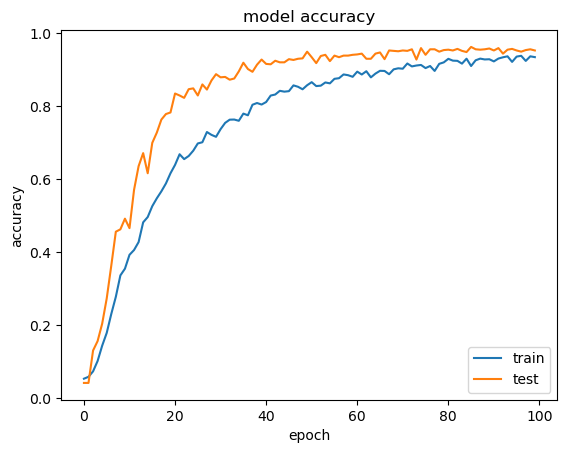


Display the evolution of the loss as a function of the training epoch
  N(Epochs)        =  100
  loss (train)     =  [5.64295768737793, 5.249140739440918, 4.847503662109375, 4.488799571990967, 3.9053308963775635, 3.531907081604004, 3.28644061088562, 2.970080614089966, 2.632359504699707, 2.4651832580566406, 2.2975270748138428, 2.304722309112549, 2.1421830654144287, 1.821075201034546, 1.8064594268798828, 1.704775333404541, 1.6078104972839355, 1.5210974216461182, 1.4434269666671753, 1.3662115335464478, 1.2452905178070068, 1.1447945833206177, 1.2023568153381348, 1.1771399974822998, 1.0898250341415405, 1.041428804397583, 0.9576000571250916, 0.9653595685958862, 0.9501268267631531, 0.9730423092842102, 0.9009579420089722, 0.9194825887680054, 0.888960599899292, 0.782848596572876, 0.8162559866905212, 0.7702035903930664, 0.8408084511756897, 0.674201488494873, 0.7136887907981873, 0.702423095703125, 0.6585343480110168, 0.6148845553398132, 0.6453502774238586, 0.5771765112876892, 0.5870935320854187

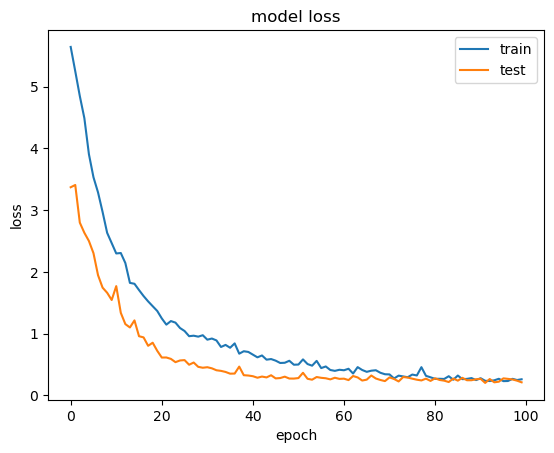


Performance summary (on test data):
29/29 - 2s - loss: 0.9998 - accuracy: 0.7944 - 2s/epoch - 64ms/step
	loss = 1.000
	accuracy = 0.794


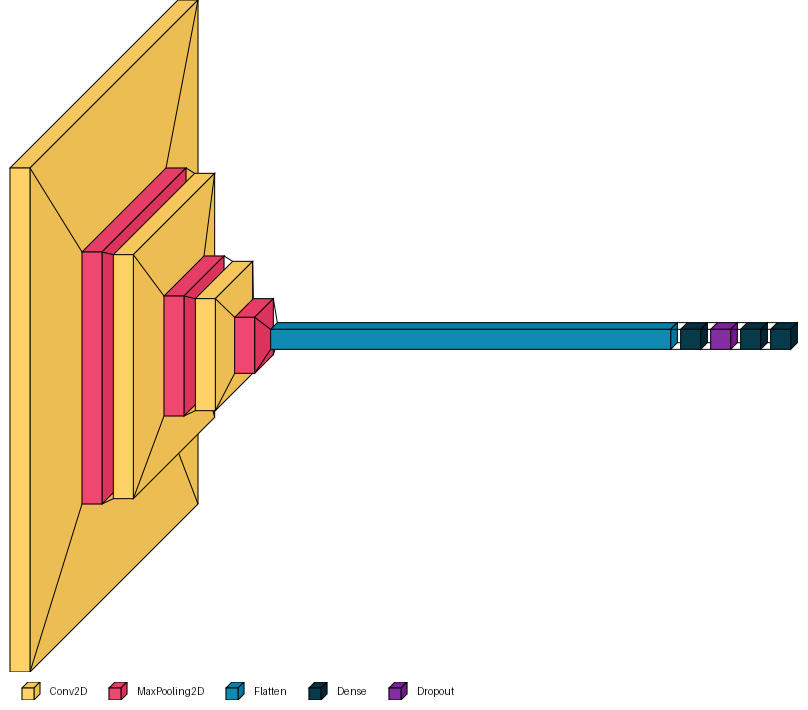

In [6]:
#some plots

import matplotlib.pyplot as plt

print("history keys = ", history.history.keys())

print("\n\033[1mDisplay the evolution of the accuracy as a function of the training epoch\033[0m")
print("  N(Epochs)        = ", Nepochs)

print("  accuracy (train) = ", history.history['accuracy'])
print("  accuracy (test)  = ", history.history['val_accuracy'])
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
plt.clf()

print("\n\033[1mDisplay the evolution of the loss as a function of the training epoch\033[0m")
print("  N(Epochs)        = ", Nepochs)
print("  loss (train)     = ", history.history['loss'])
print("  loss (test)      = ", history.history['val_loss'])

plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

print("\n\033[1mPerformance summary (on test data):\033[0m")
loss, acc = model.evaluate(test, verbose=2)
print("\tloss = {:5.3f}\n\taccuracy = {:5.3f}".format(loss, acc))

#Network design diagram

visualkeras.layered_view(model, legend = True, draw_volume = True)

29/29 [==============================] - 1s 38ms/step


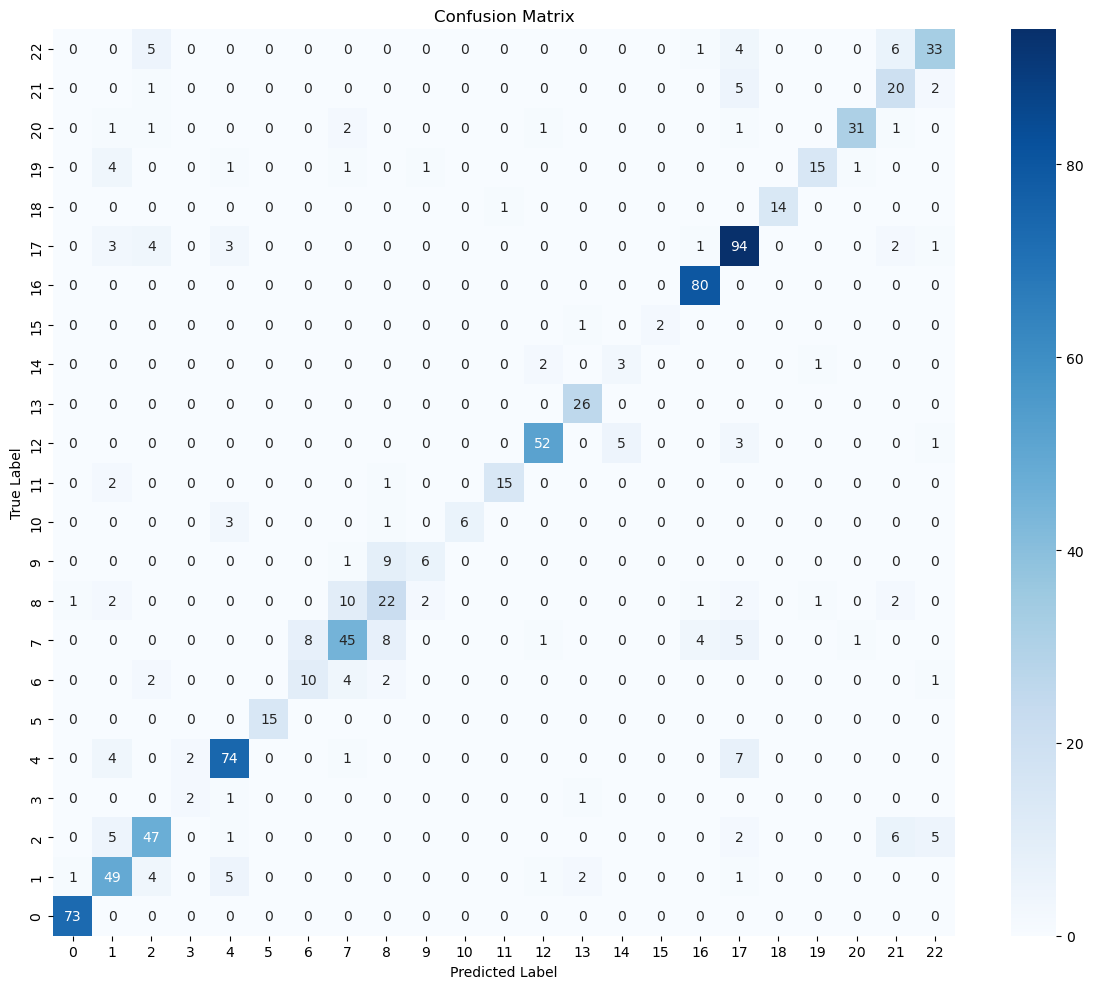

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

#Retrieve labels
y_true = test.classes
predictions = model.predict(test)
y_pred = np.argmax(predictions, axis=1)

#Compute confusion matrix
ConfusionMatrix = confusion_matrix(y_true, y_pred, labels=range(23))

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(ConfusionMatrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(23), yticklabels=range(23))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()

In [ ]:
############################################################################################
#Regression task
############################################################################################

In [2]:
#extra imports
import glob
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

In [3]:
#defining file paths for training and test CSV's
trainingFiles = ['../final_project/RNNData/train/ex_1.csv', '../final_project/RNNData/train/ex_9.csv', '../final_project/RNNData/train/ex_20.csv',
                 '../final_project/RNNData/train/ex_21.csv', '../final_project/RNNData/train/ex_23.csv', '../final_project/RNNData/train/ex_24.csv']
testFiles = ['../final_project/RNNData/test/ex_4.csv', '../final_project/RNNData/test/ex_22.csv']

train_df = pd.concat([pd.read_csv(f) for f in trainingFiles], ignore_index=True)
test_df = pd.concat([pd.read_csv(f) for f in testFiles], ignore_index=True)

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[['input_voltage', 'el_power']])
test_scaled = scaler.transform(test_df[['input_voltage', 'el_power']])

train_inputs = train_scaled[:, 0].reshape(-1, 1)
train_targets = train_scaled[:, 1]
test_inputs = test_scaled[:, 0].reshape(-1, 1)
test_targets = test_scaled[:, 1]

In [150]:
def sequences(x_data, y_data, seq_length):
    x, y = [], []
    for i in range(seq_length, len(x_data)):
        x.append(x_data[i - seq_length:i])
        y.append(y_data[i])
    return np.array(x), np.array(y)

seq_len = 90 #90 is best rn
x_train, y_train = sequences(train_inputs, train_targets, seq_len)
x_test, y_test = sequences(test_inputs, test_targets, seq_len)

x_train = x_train.reshape((-1, seq_len, 1))
x_test = x_test.reshape((-1, seq_len, 1))

In [232]:
#Model Configuration
NDense = 64
Nepoch = 25
BatchSize = 64 #64 by standard

from tensorflow.keras.layers import LSTM
model = tf.keras.Sequential([
    LSTM(64, activation = 'tanh', input_shape = (seq_len, 1), return_sequences = True), #64
    LSTM(32, activation = 'tanh', return_sequences = True),
    tf.keras.layers.Dropout(0.3), #0.1 is best
    LSTM(16, activation = 'tanh'),
    Dense(NDense, activation = 'tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dense(1, activation = 'linear')
])

model.compile(optimizer = 'adam', loss = 'mse')
model.summary()
    

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_114 (LSTM)             (None, 90, 64)            16896     
                                                                 
 lstm_115 (LSTM)             (None, 90, 32)            12416     
                                                                 
 dropout_46 (Dropout)        (None, 90, 32)            0         
                                                                 
 lstm_116 (LSTM)             (None, 16)                3136      
                                                                 
 dense_96 (Dense)            (None, 64)                1088      
                                                                 
 dense_97 (Dense)            (None, 1)                 65        
                                                                 
Total params: 33601 (131.25 KB)
Trainable params: 336

In [236]:
#Training

history = model.fit(x_train, y_train, epochs = Nepoch, batch_size = BatchSize, validation_split = 0.3)


Epoch 1/25
579/579 [==============================] - 8s 14ms/step - loss: 0.0103 - val_loss: 0.0097
Epoch 2/25
579/579 [==============================] - 7s 12ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 3/25
579/579 [==============================] - 8s 14ms/step - loss: 0.0102 - val_loss: 0.0114
Epoch 4/25
579/579 [==============================] - 8s 14ms/step - loss: 0.0104 - val_loss: 0.0111
Epoch 5/25
579/579 [==============================] - 7s 13ms/step - loss: 0.0101 - val_loss: 0.0169
Epoch 6/25
579/579 [==============================] - 9s 15ms/step - loss: 0.0101 - val_loss: 0.0111
Epoch 7/25
579/579 [==============================] - 9s 15ms/step - loss: 0.0101 - val_loss: 0.0119
Epoch 8/25
579/579 [==============================] - 8s 14ms/step - loss: 0.0100 - val_loss: 0.0113
Epoch 9/25
579/579 [==============================] - 8s 14ms/step - loss: 0.0101 - val_loss: 0.0160
Epoch 10/25
579/579 [==============================] - 8s 14ms/step - loss: 0.0100 - val_lo

569/569 [==============================] - 2s 4ms/step


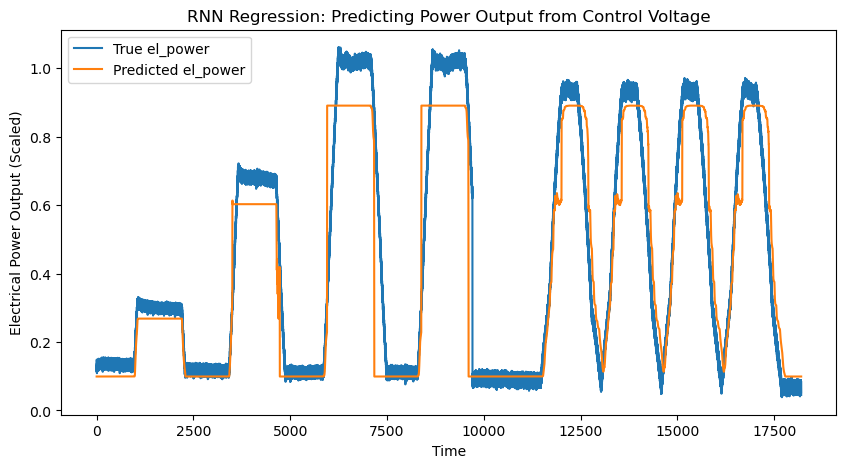

In [237]:
y_pred = model.predict(x_test)

plt.figure(figsize=(10,5))
plt.plot(y_test, label='True el_power')
plt.plot(y_pred, label='Predicted el_power')
plt.xlabel('Time')
plt.ylabel('Electrical Power Output (Scaled)')
plt.legend()
plt.title("RNN Regression: Predicting Power Output from Control Voltage")
plt.show()

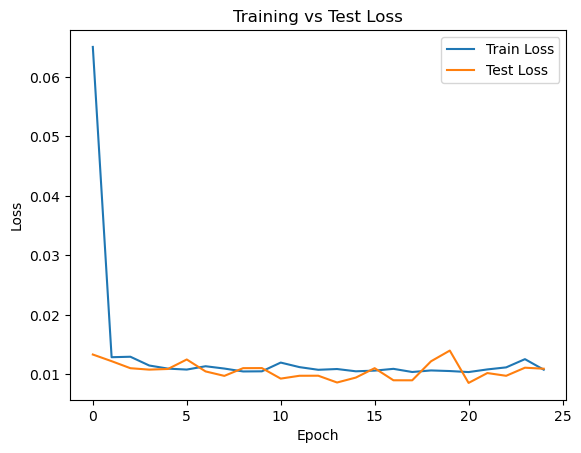

In [235]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Test Loss')
plt.show()

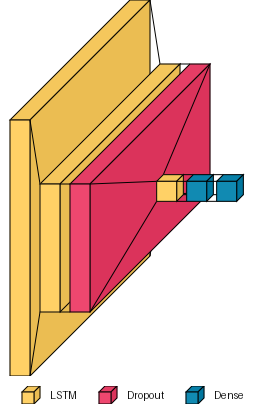

In [198]:
#Network Design diagram
import visualkeras
visualkeras.layered_view(model, legend = True, draw_volume = True)

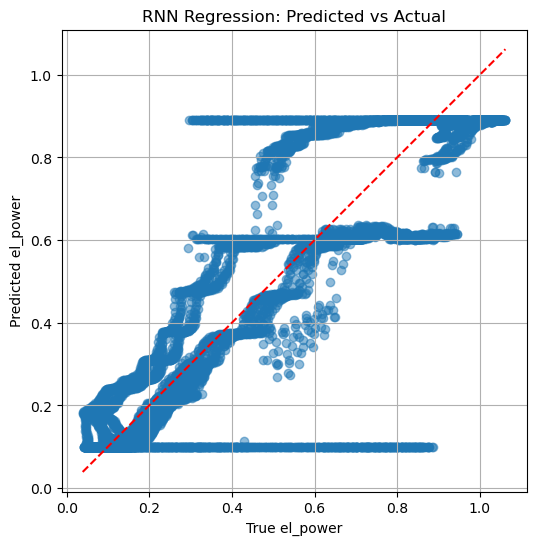

In [245]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('True el_power')
plt.ylabel('Predicted el_power')
plt.title('RNN Regression: Predicted vs Actual')
plt.grid(True)
plt.axis('equal')
plt.show()